In [1]:
import coiled

In [2]:
cluster = coiled.Cluster(
    name="github-parquet"
)

Output()

In [3]:
from distributed import Client
client = Client(cluster)
client

<Client: 'tls://10.4.9.133:8786' processes=40 threads=80, memory=306.68 GiB>

In [4]:
import dask.dataframe as dd

In [5]:
ddf = dd.read_parquet(
    's3://coiled-datasets/github-archive/github-archive-2015.parq/',
    storage_options={"anon": True, 'use_ssl': True},
)

In [6]:
ddf.head()

,user,repo,created_at,message,author
0,soumith,soumith/fbcunn,2015-01-01T01:00:00Z,"back to old structure, except lua files moved out",Soumith Chintala
1,soumith,soumith/fbcunn,2015-01-01T01:00:00Z,...,Soumith Chintala
2,soumith,soumith/fbcunn,2015-01-01T01:00:00Z,...,Soumith Chintala
3,soumith,soumith/fbcunn,2015-01-01T01:00:00Z,...,Soumith Chintala
4,radix,radix/effect,2015-01-01T01:00:00Z,put the auto-generated API docs in the reposit...,Christopher Armstrong


These are only PushEvents.

Let's do a large-scale computation that will bring down a smaller value that we can then continue processing without Coiled. For example, getting the number of PushEvents per user.

We can then calculate some summary statistics in one task.

And create some visualisations in another task.

Nothing too fancy. Let's publish and then see if it gets traffic.


1. Large computation on Coiled cluster
2. Get summary statistics (mean, )
3. Plot something and save to file.
4. Get user and author names of 1% most active users and save to file.

In [9]:
user_counts = ddf.user.value_counts().compute()

In [23]:
user_counts.memory_usage()

93902296

In [16]:
len(user_counts)

1641819

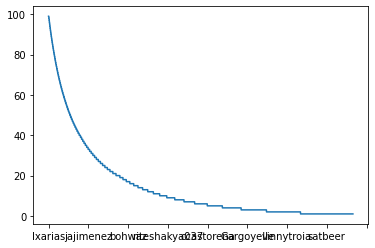

In [36]:
user_counts[user_counts < 100].plot();

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

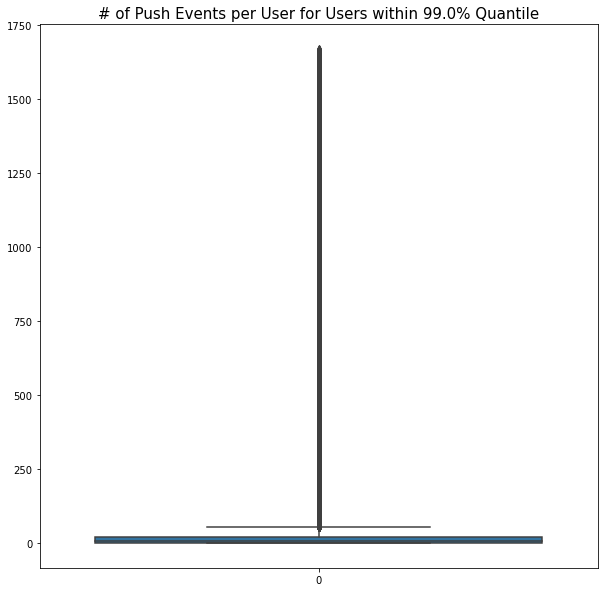

tornado.application - ERROR - Exception in callback functools.partial(<bound method IOLoop._discard_future_result of <zmq.eventloop.ioloop.ZMQIOLoop object at 0x1462854c0>>, <Task finished name='Task-4258' coro=<Cluster._sync_cluster_info() done, defined at /Users/rpelgrim/mambaforge/envs/etl/lib/python3.9/site-packages/distributed/deploy/cluster.py:104> exception=OSError('Timed out trying to connect to tls://3.236.204.48:8786 after 30 s')>)
Traceback (most recent call last):
  File "/Users/rpelgrim/mambaforge/envs/etl/lib/python3.9/site-packages/distributed/comm/tcp.py", line 398, in connect
    stream = await self.client.connect(
  File "/Users/rpelgrim/mambaforge/envs/etl/lib/python3.9/site-packages/tornado/tcpclient.py", line 275, in connect
    af, addr, stream = await connector.start(connect_timeout=timeout)
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/rpelgrim/mambaforge/

In [71]:
fig, ax = plt.subplots(figsize=(10,10))
quantile = 0.99

plt.title(f'# of Push Events per User for Users within {quantile*100}% Quantile', fontsize=15)

sns.boxplot(
    data=user_counts[user_counts < user_counts.quantile(0.999)],
)

plt.savefig(f'boxplot_{quantile*100}quantile.jpg')

In [14]:
user_counts_1000 = user_counts[user_counts > 1000]

In [15]:
len(user_counts_1000)

4239

In [20]:
user_counts_1000.index

Index(['mirror-updates', 'KenanSulayman', 'greatfirebot', 'markkcc', 'rydnr',
       'asfgit', 'diversify-exp-user', 'grid-bot', 'dsm-git',
       'openstack-gerrit',
       ...
       'dhanvi', 'sa2ajj', 'boost-commitbot', 'qnet-herwin', 'bm5w', 'Mischi',
       'lamagnifica', 'raffaellod', 'djcp', 'richelbilderbeek'],
      dtype='object', length=4239)

KeyError: False

In [13]:
subset.head()

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [ ]:
ddf.user.value_counts().compute()

In [ ]:
ddf[ddf.author==""]